In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [2]:
Random_seed = 42
# Задаем seed
np.random.seed(Random_seed)

In [3]:
df = pd.read_excel('/content/drive/MyDrive/Python/Курсовая Классическое МО/Обработанные данные.xlsx')

In [4]:
target = 'log SI'
drop = ['log IC50', 'log CC50', 'log SI', 'IC50, mM', 'CC50, mM', 'SI']

median_value = df[target].median()
df['is_above_median'] = (df[target] > median_value).astype(int)

target_df = df.drop(columns=drop)

In [5]:
# Загрузка данных
X = target_df.drop(columns=['is_above_median'])
y = target_df['is_above_median']

In [6]:
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Список моделей и их параметров для GridSearch
models_params = [
    {
        'name': 'Logistic Regression',
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'saga']
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    {
        'name': 'Gradient Boosting',
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    {
        'name': 'SVM (RBF)',
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf']
        }
    },
    {
        'name': 'Linear SVM',
        'model': LinearSVC(random_state=42, dual=False),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'loss': ['squared_hinge']
        }
    },
    {
        'name': 'k-NN',
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    {
        'name': 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5]
        }
    },
    {
        'name': 'AdaBoost',
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 1.0]
        }
    },
    {
        'name': 'Naive Bayes',
        'model': GaussianNB(),
        'params': {}
    },
    {
        'name': 'LDA',
        'model': LinearDiscriminantAnalysis(),
        'params': {}
    },
    {
        'name': 'QDA',
        'model': QuadraticDiscriminantAnalysis(),
        'params': {}
    },
    {
        'name': 'SGD Classifier',
        'model': SGDClassifier(random_state=42),
        'params': {
            'loss': ['hinge', 'log_loss'],
            'alpha': [0.0001, 0.001, 0.01]
        }
    },
    {
        'name': 'Ridge Classifier',
        'model': RidgeClassifier(random_state=42),
        'params': {
            'alpha': [0.1, 1.0, 10.0],
            'solver': ['auto', 'svd']
        }
    }
]

In [9]:
# Словарь для сохранения лучших моделей
best_models = {}

# DataFrame для метрик
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC'])

# Обучение и оценка моделей
for mp in models_params:
    print(f"Training {mp['name']}...")

    # Для моделей без параметров (например, Naive Bayes) используем обычный fit
    if not mp['params']:
        model = mp['model']
        model.fit(X_train, y_train)
        best_models[mp['name']] = model
    else:
        grid_search = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[mp['name']] = grid_search.best_estimator_

    # Предсказания
    y_pred = best_models[mp['name']].predict(X_test)
    y_proba = best_models[mp['name']].predict_proba(X_test)[:, 1] if hasattr(best_models[mp['name']], 'predict_proba') else None

    # Расчет метрик
    metrics = {
        'Model': mp['name'],
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted'),
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

    results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)

Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-9-40754070.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)


Training Random Forest...
Training Gradient Boosting...
Training SVM (RBF)...
Training Linear SVM...
Training k-NN...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-9-40754070.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)


Training Decision Tree...
Training AdaBoost...
Training Naive Bayes...
Training LDA...
Training QDA...
Training SGD Classifier...


/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-9-40754070.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty 

Training Ridge Classifier...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=4.36781e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/tmp/ipython-input-9-40754070.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([metrics])], ignore_index=True)


In [10]:
results_df.sort_values(by='ROC-AUC', ascending=False)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
1,Random Forest,0.676617,0.675841,0.676617,0.675808,0.723118
10,QDA,0.641791,0.682527,0.641791,0.631552,0.721774
2,Gradient Boosting,0.656716,0.657623,0.656716,0.657023,0.709677
7,AdaBoost,0.656716,0.655816,0.656716,0.655858,0.662684
9,LDA,0.616915,0.616641,0.616915,0.616763,0.651633
3,SVM (RBF),0.611940,0.666519,0.611940,0.554504,0.648248
5,k-NN,0.592040,0.595983,0.592040,0.592545,0.630426
6,Decision Tree,0.572139,0.572805,0.572139,0.572416,0.577559
0,Logistic Regression,0.537313,0.288706,0.537313,0.375598,0.537485
8,Naive Bayes,0.467662,0.752463,0.467662,0.303578,0.446087


In [11]:
best_roc_model_name = results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']
best_roc_model = best_models[best_roc_model_name]
print(f"\nЛучшая модель по ROC-AUC: {best_roc_model_name} (ROC-AUC = {results_df['ROC-AUC'].max():.3f})")


Лучшая модель по ROC-AUC: Random Forest (ROC-AUC = 0.723)


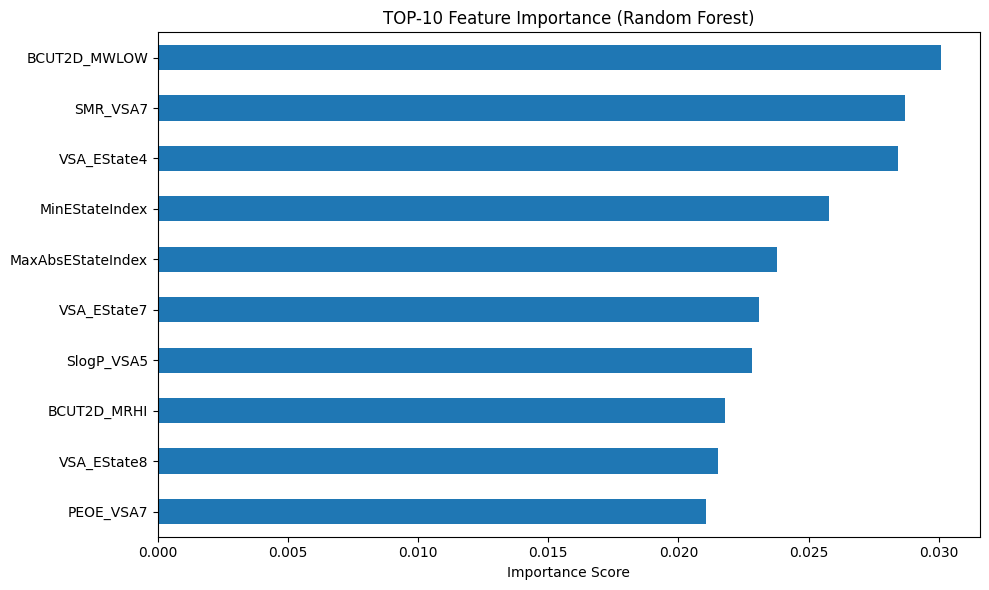

In [12]:
plt.figure(figsize=(10, 6))

importances = best_roc_model.feature_importances_
features = X_train.columns if hasattr(X_train, 'columns') else range(len(importances))
pd.Series(importances, index=features).sort_values(ascending=True).tail(10).plot(kind='barh')
plt.title(f'TOP-10 Feature Importance ({best_roc_model_name})')

plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

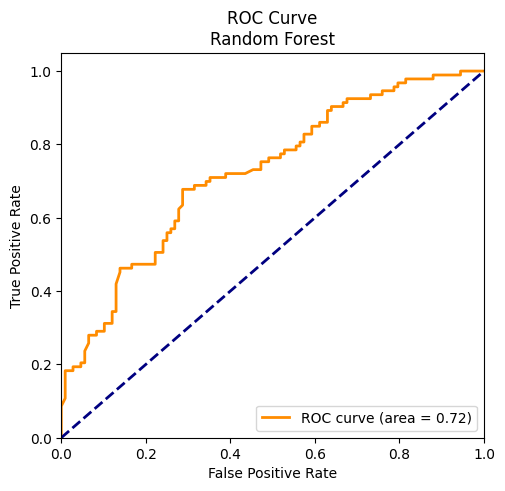

In [13]:
# ROC-AUC кривая
plt.figure(figsize=(12, 5))

y_proba = best_roc_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve\n{best_roc_model_name}')
plt.legend(loc="lower right")

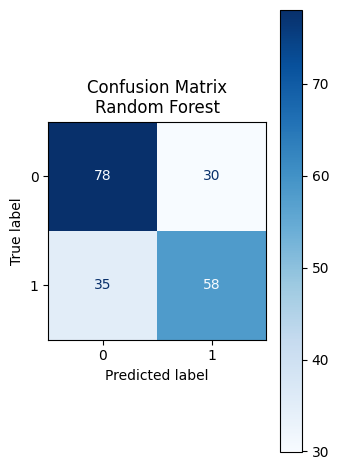

In [14]:
# Confusion Matrix
y_pred = best_roc_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.subplot(1, 2, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=best_roc_model.classes_)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title(f'Confusion Matrix\n{best_roc_model_name}')

plt.tight_layout()
plt.show()